In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import copy
random.seed(42)

In [2]:
# import the medium.csv file
data = pd.read_csv('medium.csv', header=None)
data.head()
print(data.shape)

(100, 2)


In [3]:
# convert the data to a list of tuples
cities = list(data.itertuples(index=False, name=None))
print(cities[:5])  # print first 5 cities to verify
print(f'Total number of cities: {len(cities)}')

[(0.41799245647424926, 0.34411192527552814), (0.05893815561138716, 0.679530288365254), (0.4784590047029411, 0.053814995892541566), (0.52115942968839, 0.8066037608804467), (0.5806320199484606, 0.6029501879313506)]
Total number of cities: 100


In [151]:
# global variables
POP_SIZE = 250 # population size
MUT_RATE = 0.1 # mutation rate
CROSS_RATE = 0.9 # crossover rate
GENS = 500 # number of generations
ELITISIM = 2 # number of top individuals to carry over  

In [152]:
# create initial population
def create_init_population(pop_size, num_cities)->list[list[int]]: 
    
    ##################################################
    # Your Code Below This Line
    ##################################################  
    pop = []
    for i in range(pop_size): 
        p = list(range(num_cities))
        random.shuffle(p)
        pop.append(p)
    return pop

# each individual in the population is represented as a list of city indices
population = create_init_population(POP_SIZE, len(cities))

In [153]:
# create initial population
def cr(pop_size, num_cities)->list[list[int]]: 
    
    ##################################################
    # Your Code Below This Line
    ##################################################  
    pop = []
    p = list(range(num_cities))
    for i in range(pop_size): 
        random.shuffle(p)
        pop.append(p)
        p = copy.deepcopy(p)
    return pop

# each individual in the population is represented as a list of city indices
population = create_init_population(POP_SIZE, len(cities))

In [156]:
def e_dist(a, b): 
    x1, y1 = a
    x2, y2 = b
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
# create the distance matrix
def calculate_distance_matrix(cities)->list[list[float]]:
    
    ##################################################
    # Your Code Below This Line
    ##################################################   
    mat = []
    for i in range(len(cities)): 
        temp = []
        for j in range(len(cities)): 
            temp.append(e_dist(cities[i], cities[j]))
        mat.append(temp)
    return mat

# each entry distance_matrix[i][j] represents the distance from city i to city j so i==j distance is 0
distance_matrix = calculate_distance_matrix(cities)

In [158]:
# define any necessary utility functions and genetic algorithm related functions here

##################################################
# Your Code Below This Line
##################################################
def route_cost(route, distance_mat): 
    t = 0
    for i in range(len(route) - 1): 
        t += distance_mat[route[i]][route[i + 1]]
    t += distance_mat[route[-1]][route[0]]
    return t


def elitism(pop, costs): 
    ranked = sorted(zip(pop, costs), key=lambda x: x[1])
    return [i[:] for i, _ in ranked[:ELITISIM]]

def tournement_selection(pop, costs, k=5): 
    routes = random.sample(range(len(pop)), k)
    best_min = routes[0]
    for i in routes[1:]: 
        if costs[i] < costs[best_min]: 
            best_min = i
    return pop[best_min]

def inversion(route): 
    route_copy = copy.deepcopy(route)
    if random.random() > MUT_RATE: 
        return route_copy
    i, j = sorted(random.sample(range(len(route)), 2))
    route_copy[i:j] = list(reversed(route_copy[i:j]))
    return route_copy
    

In [159]:
## mutations

def scramble(route): 
    route_copy = route[:]
    if random.random() > MUT_RATE: 
        return route_copy
    x, y = sorted(random.sample(range(len(route_copy)), 2))
    r = route_copy[x:y]
    random.shuffle(r)
    route_copy[x:y] = r
    return route_copy

def displacement(route): 
    child = route[:]
    if random.random() > MUT_RATE: 
        return child
        
    s, e = sorted(random.sample(range(len(child)), 2))
    
    x = child[s:e]
    del child[s:e]
    n = random.randint(0, len(child))
    
    child = child[:n] + x + child[n:]
    return child
    
def insertion(route): 
    child = route[:]
    if random.random() > MUT_RATE: 
        return child
    x, y = random.sample(range(len(child)), 2)
    a = child[x]
    del child[x]
    child = child[:y] + [a] + child[y:]
    return child

def inversion(route): 
    child = route[:]
    if random.random() > MUT_RATE: 
        return child
    s, e = sorted(random.sample(range(len(child)), 2))
    child[s:e] = child[s:e][::-1]
    return child
def displaced_inversion(route): 
    child = route[:]
    if random.random() > MUT_RATE: 
        return child
    s, e = sorted(random.sample(range(len(child)), 2))

    x = child[s:e]
    del child[s:e]
    n = random.randint(0, len(child))
    child = child[:n] + x[::-1] + child[n:]
    return child
    
## crossovers

def order_based(p1, p2): 
    if random.random() > CROSS_RATE: 
        return p1[:]
    size = len(p1)
    
    a, b = sorted(random.sample(range(len(p1)), 2))

    child = [-1] * size
    child[a:b] = p1[a:b]
    fill = [p for p in p2 if p not in child]

    idx = 0
    for i in range(size): 
        if child[i] == -1: 
            child[i] = fill[idx]
            idx += 1
            
    return child


def postion_based(p1, p2): 
    if random.random() > CROSS_RATE: 
        return p1[:]

    size = len(p1)

    k = random.randint(1, size // 2)
    positions = random.sample(range(size), k)

    child = [-1] * size

    for pos in positions: 
        child[pos] = p1[pos]
    fill = [p for p in p2 if p not in child]

    idx = 0
    for i in range(size): 
        if child[i] == -1: 
            child[i] = fill[idx]
            idx += 1
    return child
    

In [163]:
# implement main genetic algorithm loop here 
# performing selection, crossover, mutation
# it should run for GENS generations and use POP_SIZE, MUT_RATE, CROSS_RATE as parameters
# at the end, store the best route found and the best route's total distance between 
# consecutive cities in the route including the return to the starting city

##################################################
# Your Code Below This Line
##################################################

def ga(cities): 
    pop = create_init_population(POP_SIZE, len(cities))
    distance_matrix = calculate_distance_matrix(cities)

    
    best_cost = float('inf')
    best_route = None

    for gen in range(GENS): 
        
        costs = [route_cost(p, distance_matrix) for p in pop]

        min_cost = min(costs)
        if min_cost < best_cost: 
            best_cost = min_cost
            best_route = pop[costs.index(min_cost)]

        new_pop = elitism(pop, costs)
        while len(new_pop) < POP_SIZE: 
            parent1 = tournement_selection(pop, costs)
            parent2 = tournement_selection(pop, costs)
            child = order_based(parent1, parent2)
            # mutation = random.choice([inversion, displaced_invers])
            # child = mutation(child)
            child = inversion(child)
            new_pop.append(child)
        pop = new_pop

        if gen % 100 == 0: 
            print(f'gen: {gen} | cost: {best_cost}')


    return best_route, best_cost


In [164]:
a, b = ga(cities)

gen: 0 | cost: 43.201063035741825
gen: 100 | cost: 16.278459025314994
gen: 200 | cost: 12.097514895932092
gen: 300 | cost: 10.55098941387201
gen: 400 | cost: 9.30321428937158


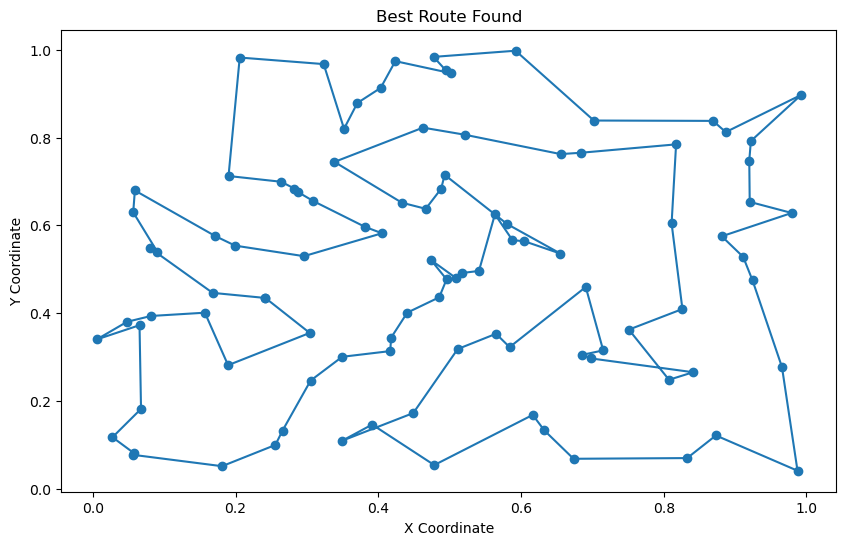

In [165]:
plot_route(cities, a)

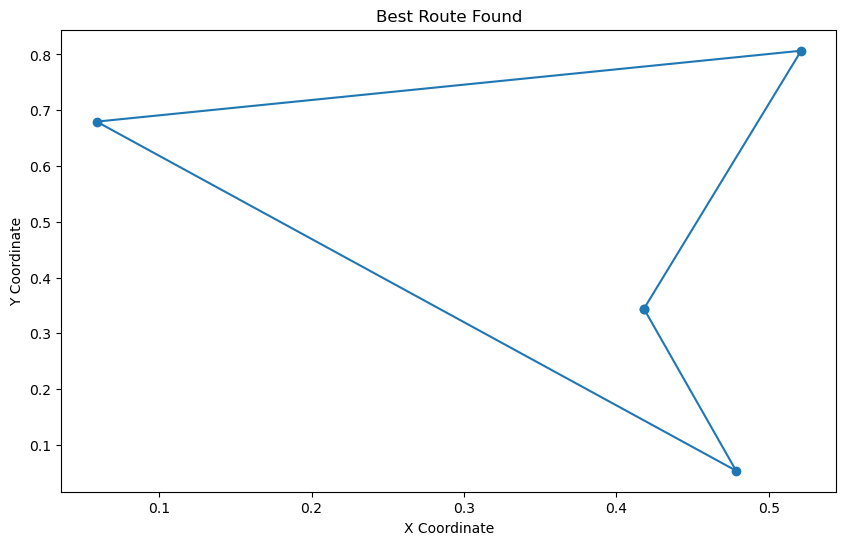

In [17]:
# utility function to plot the best route found
def plot_route(cities, route):

    # following code:
    # appending start city to end
    # returns list of tuples [(x, y),...]
    route_cities = [cities[i] for i in route] + [cities[route[0]]] 
    # following code: 
    # *unpacks the list of tuples into tuples (x1,y1), (x2,y2), ...
    # by using the zip function we combine all x coordinates and y coordinates separately into two tuples
    x, y = zip(*route_cities)

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, marker='o')
    plt.title('Best Route Found')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()

best_route = [0, 2, 1, 3] # replace with actual best route found from GA
plot_route(cities, best_route)